# Genetic Algorithms

The genetic algorithm is a probabilistic search algorithm that iteratively transforms a set (called a population) of mathematical objects (typically fixed-length binary character strings), each with an associated fitness value, into a new population of offspring objects using the Darwinian principle of natural selection and using operations that are patterned after naturally occurring genetic operations, such as crossover (sexual recombination) and mutation.)

In this section, we will demonstrate some basic implementations of Simple Genetic Algorithms (SGA), Real-valued GA, as well as the use of GA to generate permutations. At the end, we'll show how real-valued GA can be applied to a shortest-path search.

## Example: Bike pricing using Simple Genetic Algorithm
Assume that a company wants to design a new bicycle, and needs to consider the following costs:
- $700,000 for manufacturing setup, marketing, etc.
- $110 for each bike produced

Based on similar bikes, the company expects sales to follow this demand curve:

$Q= 70,000 - 200P$,<br>
where $P$ is the price, and $Q$ is the number of units sold at that price

For example:
- At $0, the company would give away 70,000 bikes for free
- At $300, the company would sell $70,000-200*300=10,000$ bikes
- At $350, the company wouldn't sell at anything at all.

Profit would be calculated as following:

$Profit=Sales-Costs$<br>
$Profit=P(70,000-200P)-(700,000+110(70,000-200P))$<br>
$Profit=-200P^2+92,000P-8,400,000$

### Implementation using SGA
Simple Genetic Algorithms represent genes as binary values, and mutates those genes through binary operations. Essentially, they replicate the behaviour of genotypes in genetics, where genotypes (actual DNA coding) produce phenotypes (genetic traits). 

In [187]:
import random
import math

# SGA Parameters
num_gen = 3000
pop_size = 5
crossover_prob = 0.8
mutation_prob = 0.2
num_parents = 2

# Solution representation
chromosome_length = 9
best_score = -100000 # Initialize the "best solution"next

In [181]:
# Generate an initial random population
def init_pop(pop_size, chromosome_length):
    ints = [random.randint(0,350) for i in range(pop_size)]
    strs = [bin(n)[2:].zfill(chromosome_length) for n in ints]
    bins = [[int(x) for x in n] for n in strs]
    return bins

populations = init_pop(pop_size, chromosome_length)
parents=[]

In [182]:
def fitness_score():
    global populations, best_score
    fit_value = []
    num = []
    for i in range(len(populations)):
        num.append(int("".join(str(x) for x in populations[i]), base=2))  # convert binary to decimal
        fit_value.append(-200 * math.pow(num[i],2) + 92000 * num[i] - 8400000)
    fit_value, populations = zip(*sorted(zip(fit_value, populations), reverse=True))
    best_score = fit_value[0]
    return fit_value, best_score


This fitness function essentially determines how "good" a particular offspring is. It first converts each unit in the population to a binary number (the genotype), and then returns the "best" offspring.

In [183]:
# Random parent selection
def selectparent():
    global parents
    parents=random.sample(populations, num_parents)
    
    return parents

In [184]:
# Apply 1-point crossover
def crossover():  
    global parents
    if crossover_prob > random.random():
        cross_point = random.randint(0,chromosome_length)
        parents+= tuple([(parents[0][0:cross_point +1] +parents[1][cross_point+1:(chromosome_length+1)])])
        parents+= tuple([(parents[1][0:cross_point +1] +parents[0][cross_point+1:(chromosome_length+1)])])
    
    return parents

The crossover function here first determines if a crossover takes place (using the `crossover_prob`) and then selects a random crossover point in the chromosome. Using 1-point crossover, the bottom halves are switched the parents.

In [185]:
# Apply mutation

# Alter each gene independently with a probability mutation_prob
def mutation() :
    global populations, parents
  
    for i in range(len(parents)) :
        for j in range(chromosome_length) :
            if mutation_prob > random.random():
                if parents[i][j]==1:
                    parents[i][j]=0
                else:
                    parents[i][j]=1
                    
                populations = parents
    
    return populations

Best score: 1775000.0
Best solution 185


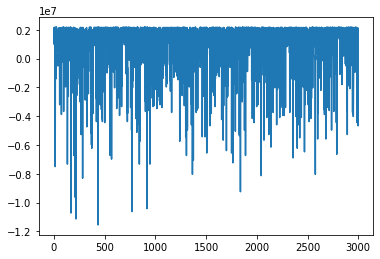

In [186]:
# The actual SGA is rather simple
scores = [] # track the best_scores across generations for visualization
for generations in range(num_gen):
    fitness_score()
    selectparent()
    crossover()
    mutation()
    scores.append(best_score)
    
fitness_score() # Generate the fitness scores again, as the last operation was a mutation
print("Best score:", best_score)
print("Best solution", int(''.join(str(x) for x in populations[0]), base=2))

## Example: Real-value Genetic Algorithm shortest path search
For the examples in this section, we will move past our University of Toronto search space in the previous section in favour of a more complex environment. This is the kind of network which really benefits from Genetic Search Algorithms.

Let's consider the road network in Vaughan, a municipality to the north of Toronto:

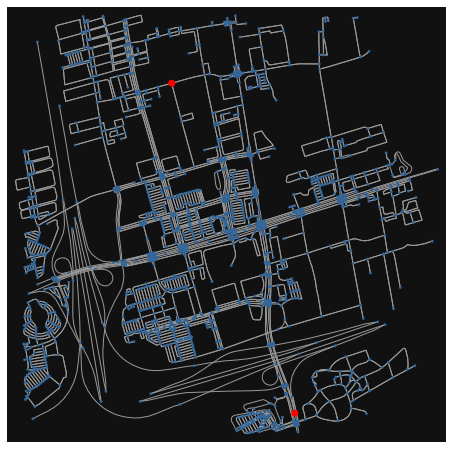

In [4]:
import osmnx

G = osmnx.graph_from_address('vaughan', dist=1400)

origin = 29658954
destination = 701446851

highlighted = [origin, destination]

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

For this example, we'll be attempting to search for the shortest route between two points highlighted in red.

### The Algorithm

There are many ways to design a genetic algorithm; the below is only one of them.

1. We will need a fitness function to determine which offspring to keep in each generation. This will be the length of the route generated (we want to minimize this).
2. As we will be doing a real-value (non-binary) GA, out phenotype is the same as our genotype.
3. Our GA implementation is "kind of" steady state: we probabilistically choose the best routes to be the parents of the next generation. More on this later.
4. We will be doing [1-point crossover](https://en.wikipedia.org/wiki/Crossover_(genetic_algorithm)#One-point_crossover).
5. Route mutations take place by deleting a random number of genes/nodes and trying to stitch that gap. Keep in mind this is time-intensive.
6. Selection is based on fitness-proportionate criteria.

The actual algorithm (in pseudo-code) looks like this:

<style>
i {font-weight:normal}
span {font-weight:normal}
</style>

<div style="background-color: rgba(0,0,0,0.0470588);padding:10px;font-family:monospace;">
    <b>GENETIC_ALGORITHM</b>(<i>source</i>,<i>destination</i>, <i>num_of_generations</i>. <i>pool_size</i>) <b>return</b> a <i>route</i>
    <div style='padding-left:20px;'>
        <i><font color="green">pool</font></i> &larr; <span>random-routes between <i>source</i> and <i>destination</i></span><br><br>
        for <i>num_of_generations</i> do<br>
        <div style='padding-left:20px;'>
            <i><font color="orange">parents_first_gen</font></i> &larr; <span>select number of best routes from <i><font color="green">pool</font></i></span><br>
            <i><font color="blue">parents_second_gen</font></i> &larr; <span>crossover <i><font color="orange">parents_first_gen</font></i></span><br>
            <i><font color="purple">parents</font></i> &larr; <span>mutate <i><font color="blue">parents_second_gen</font></i></span><br>
            <i><font color="green">pool</font></i> &larr; <span>offspring of <i><font color="purple">parents</font></i></span><br>
            remove duplicates from <i><font color="green">pool</font></i> and add random routes to compensate any removal<br>
        </div>
        endfor<br>
        <i>route</i> &larr; best <i>route</i> in <i><font color="green">pool</font></i><br>
        return <i>route</i>
    </div>
</div>

#### Mutation
Our algorithm "mutates" a child (route) by deleting a node between two nodes in the child, and attempting to fill in the gap with alternate nodes. If you recall the way we generated "children" for Beam Search and Hill climbing in previous sections, this uses the same idea.

In [1]:
from smart_mobility_utilities.children import shortest_path_with_failed_nodes_single
import random
import math

def mutate(G, route):
    source = route[0]
    destination = route[len(route) - 1]

    failed = random.choice(route)

    path = shortest_path_with_failed_nodes_single(G, route, [failed])

    # This method could fail because of a lot of factors relating to the graph structure
    # Check the documentation fo the shortest_path_with_failed_nodes to learn more
    while path == math.inf:
        failed = random.choice(route)
        path = shortest_path_with_failed_nodes_single(G, route, [failed])
    
    return path

#### Crossover
Rather than selecting a random point to "crossover", we look for a common node between the two routes.

In [2]:
import itertools
from smart_mobility_utilities.common import probability

def cross_over(route_1, route_2):
    origin = route_1[0]
    destination = route_1[len(route_1) - 1]

    intersection = [*itertools.filterfalse(\
                    lambda element : element in [origin, destination] ,\
                    list(set(route_1) & set(route_2)))]
    
    if len(intersection) == 0: return route_1 # if there is not common node, just return the first route

    cross_over_point = random.choice(intersection)
    first_point = route_1.index(cross_over_point)
    second_point = route_2.index(cross_over_point)

    if probability(0.5):
        return route_1[:first_point] + route_2[second_point:]
    else:
        return route_2[:second_point] + route_1[first_point:]

#### Offspring
The method for generating offspring is similar to that of mutation, but rather than choosing a random node for mutation, we choose nodes in order starting from the second in the route, up to the second-to-last. This limitation is caused by that fact that we cannot remove either the source or destination nodes.

#### Duplicates
Our offspring will likely result in many duplicates, as most routes will closely ressemble each other. To account for this, we remove any duplicates and replace them with new randomly generated routes. This also ensures population diversity.

### The code

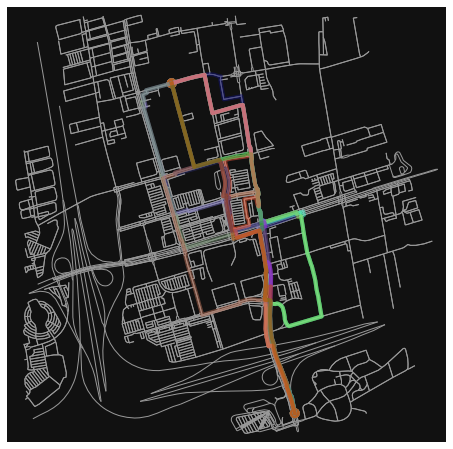

In [5]:
from smart_mobility_utilities.common import randomized_search

# Configure some parameters
n_gen = 20 # Anything above 20 will take some time but yield much better results
pool_size = 15 # Number of routes in each generation
parents_num = 3 # Needs to be a factor of pool_size

# Initialize the pool
pool = [randomized_search(G,origin,destination) for _ in range(pool_size)]

# Plot the pool on a map
random_hexa = lambda: random.randint(0,255) # generate random hexadecimal color
rc = ['#%02X%02X%02X' % (random_hexa(),random_hexa(),random_hexa()) for _ in range(pool_size)]
fig, ax = osmnx.plot_graph_routes(G, pool, route_colors=rc, route_linewidth=6, node_size=0)

The following code will take quite a bit of time to run.

In [6]:
from tqdm.notebook import tqdm
from smart_mobility_utilities.common import cost, flatten
from smart_mobility_utilities.children import get_children
import heapq

# A function to randomly select the initial parents
def select_best(pool, num_of_choices, probability_dist):
        return random.choices(population=pool, weights=probability_dist, k= num_of_choices)


states = []

for gen in tqdm(range(n_gen)):
    weights = [cost(G,route) for route in pool]
    parents_1 = select_best(pool, parents_num, weights)

    # Crossover every pair in parents, this means nP2 routes
    parents_2 = [cross_over(route_1,route_2) for route_1,route_2 in itertools.product(parents_1, repeat=2)]
    # Select the best
    parents_2 = heapq.nsmallest(parents_num, parents_2, key=lambda route: cost(G,route))

    # Mutate the parents
    parents = [mutate(G,route) for route in parents_2]

    # Generate the offspring for each parent -- each parent generates pool_size/parents_num children
    pool = flatten([get_children(G,route,num_children=pool_size//parents_num) for route in parents])

    # Remove duplicates
    pool = [*map(list, list(set(map(tuple,pool))))]
    num_removed = pool_size - len(pool) + 1
    # Replace the removed ones
    pool.extend([randomized_search(G,origin,destination) for _ in range(num_removed)])

    # Track the costs at each generation
    states.append(cost(G, min(pool, key = lambda route : cost(G, route))))

# Retrieve the final best route
route = min(pool, key=lambda route: cost(G,route))

  0%|          | 0/20 [00:00<?, ?it/s]

Cost of the route: 2800.424


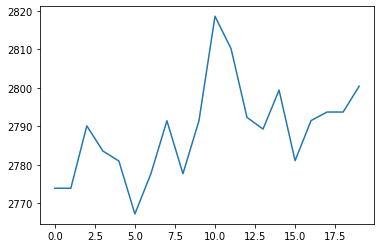

In [7]:
from smart_mobility_utilities.viz import draw_route
import matplotlib.pyplot as plt
print("Cost of the route:",cost(G,route))
ax = plt.plot(states)

In [8]:
draw_route(G,route, zoom=13)

Map(center=[43.7907708, -79.5414667], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…